# Flight Delay Prediction - GBT Toy Example
UC Berkeley, School of Information  
Authors: Tim Chen, Eugene Shen, Yang Jing, Pino Gei  
Notebooks: [Model (Main Notebook)](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/4135716278511793) | [EDA](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714) | [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683) | [GBT Toy Example](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441189954/command/1553213441189955)

## Notebook Setup

In [0]:
# spark
import pyspark.sql
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.window import Window 
from pyspark.ml import Pipeline

# analytics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# others
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# plot configs 
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)

# config constants
IS_LOCAL = False # set true if running at local machine
if IS_LOCAL:
    app_name = "w261_fp"
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
    sc = spark.sparkContext
    sqlContext = SQLContext(sc)
    
    ROOT = './'
    PARQ_AIR_2015_Q1 = ROOT + 'data/3m'
else:
    # prefixes
    ROOT                 = 'dbfs:/mnt/mids-w261/datasets_final_project/'
    ROOT_TEAM30_DBFS     = 'team_30/' # DBFS root mostly for pandas reading; pandas has no write access to it
    ROOT_TEAM30_URL      = 'dbfs:/team_30/' # mostly for dbutils/spark

## Toy Example (GBT)

We take a toy training dataset to explain the math behind GBT, which is the algorithm used in our final model.
The toy dataset consists of 8 features and a  binary lable, "delay/no delay". It contains 952 rows.

Step 1: get the log of odds of delay:

$$ log(\frac{delay}{non-delay}) $$

Step 2: convert log odds to probablity:
$$ \frac {e^{logodds}}{1 + e^{logodds}} $$

and then get the pseudo residuals 

$$ actual\ label - predicted\ probability $$

Step 3: 
build a shallow decision tree to predict the pseudoresiduals from step 2 and train it on the feature set. 
Each leaf of that tree contains one or more flights.
calculate the output from that tree, for each leaf. If a leaf contains multiple predictions/flights, calculate the log odds for the leaf using this formula:

$$ \frac {\sum(log odds)}{\sum((p_{prior}) \cdot (1- p_{prior}))} $$

Note this step is hidden in sklearn decision tree we used and the output is already a single-valued log odds for that leaf. 

Step 4: update original log odds  for each leaf with the new predictions, regularized with a learning rate. For the example, this is a parameter we can change in the funciton. 

$$ log odds + learning rate \cdot (output\ in\ step\ 3) $$

Step 5: use the value from step 4, convert it to probabilities and subtract it from the actual/observed labels to get the updated pseudo residuals..

This runs in a loop until maxIter = 0 and/or the predicted probability reaches a local minimum. These series of steps builds the GBT model, based on the training set.
In the example, the default is 10 loops.

In [0]:
# load the toy dataset
toy_df = spark.read.parquet(f'{ROOT_TEAM30_URL}/toy_data.parquet')

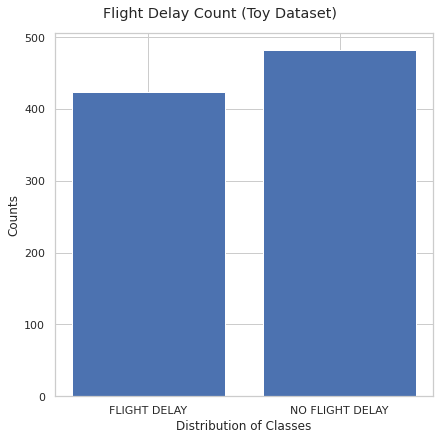

In [0]:
# plot a bar chart for class count
delay = toy_df.where(f.col('DEP_DEL15') == 1).count()
no_delay = toy_df.where(f.col('DEP_DEL15') == 0).count()
pddf = pd.DataFrame(
            {'FLIGHT DELAY': [delay],
             'NO FLIGHT DELAY': [no_delay]})

sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('Flight Delay Count (Toy Dataset)')
ax.bar(pddf.columns, pddf.iloc[0,:])
ax.set_xlabel("Distribution of Classes")
ax.set_ylabel("Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 

plt.show()
pass

### Step 1
 - Get the log of odds of delay as the baseline prediction
 - Convert log odds to baseline probability

In [0]:
toyrdd = toy_df.rdd
sumOutput = toyrdd.map(lambda x: x[-1]).sum()
countOutput = toyrdd.map(lambda x: x[-1]).count()
odds = sumOutput/(countOutput-sumOutput)
log_odds = np.log(odds)

print("Count of delays:", sumOutput)

# baseline log odds
log_odds_arr = np.full((countOutput,), log_odds)

def odds_to_probability(x):
    return np.exp(x)/(1 + np.exp(x))

# baseline probability
baseline_probability = odds_to_probability(log_odds)
BASELINE = np.full((countOutput,), baseline_probability)

Count of delays: 423

### Step 2
 - Obtain observed values from RDD
 - Obtain features from RDD

In [0]:
def get_observed_val(dataRDD):
    '''get the labels'''
    observed_val = dataRDD.map(lambda x: (x[-1])).collect() 
    return np.array(observed_val)

def get_features(dataRDD):
    '''get the features'''
    feat = dataRDD.map(lambda x: x[:-1]).collect() #features
    return np.array(feat)
  
observed = get_observed_val(toyrdd)
features = get_features(toyrdd)

### Step 3
 - Calculate pseudo-residuals, as defined by `observed values - predicted probabilities`
 - Use features to build a decision tree which is fitted on the calculated pseudo-residuals
 - Scale the output of each leaf by learning rate *alpha*
 - Obtain updated log odds and convert updated log odds to updated probability

In [0]:
# we wrap step 3-5 in a function
def sample_gbt_predict(n=10, alpha=0.1):
    '''predits probability of delay
    input: initial baseline probability and log odds
     hyperparameters: number of trees (n)
                       learning rate (alpha)
      output: predicted probabilities of delay'''
    new_prob = baseline_probability 
    new_LO = log_odds
    for i in range(n):
        X = features
        Y = observed - new_prob
        clf = DecisionTreeRegressor(max_leaf_nodes=32, random_state=0)
        # fit single DT to predict the pseudo-residuals
        clf.fit(X, Y)
        # get output from the DT, using the train set features
        y_2 = clf.predict(X)
        # update log odds with predicted y_2. use learning rate of 0.1
        new_LO = new_LO + (alpha * y_2)
        # convert log odds to probability
        new_prob = odds_to_probability(new_LO)
    return new_prob
        

### Step 4
 - Obtain prediction. Threshold value is defined as 0.5.

In [0]:
# get a prediction based on the probabilities
new_prob = sample_gbt_predict(n=10,alpha=0.1)
predictions = np.zeros(new_prob.shape)
for i in range(len(new_prob)):
    if new_prob[i] >= 0.5:
        predictions[i] = 1
    
print("Count of predicted delays:", sum(predictions==1.0))

Count of predicted delays: 290

### Step 5
 - Loop across GBT models with varying complexities (tree count)

Count of predicted delays: 423 delays for 1000 iterations.

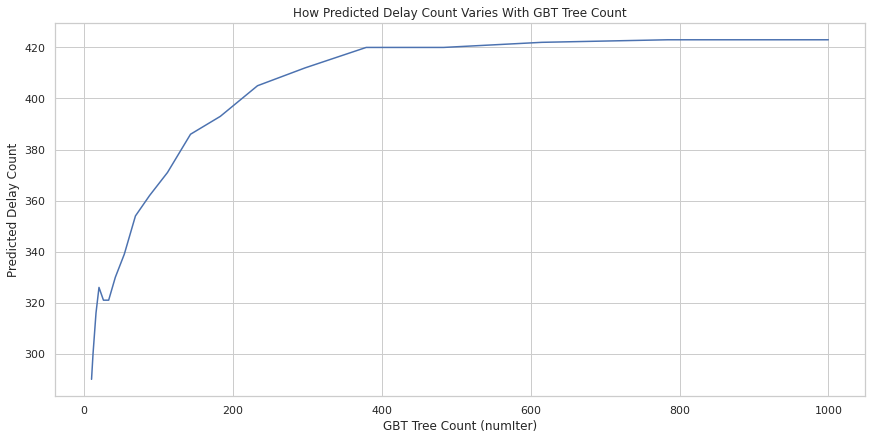

In [0]:
tree_count = np.logspace(1, 3.0, num=20, dtype = int)
predicted_counts = []

for count in tree_count:
  new_prob = sample_gbt_predict(n=count,alpha=0.1)
  predictions = np.zeros(new_prob.shape)
  for i in range(len(new_prob)):
      if new_prob[i] >= 0.5:
          predictions[i] = 1
  sum_predicted = sum(predictions==1.0)
  predicted_counts.append(sum_predicted)
print("Count of predicted delays:", predicted_counts[-1], "delays for", tree_count[-1],  "iterations.")
  
t = tree_count
s = predicted_counts

sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(t, s)
ax.set(xlabel='GBT Tree Count (numIter)', ylabel='Predicted Delay Count',
       title='How Predicted Delay Count Varies With GBT Tree Count')
plt.show()
pass

Our toy model shows how the predicted delay count reaches the actual delay count (423), as the number of iterations (trees used) increase.